In [1]:
import numpy as np
import os
import sys
import pandas as pd


import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from GlobalUtils import GlobalUtils
utils = GlobalUtils()
os.chdir(utils.base_dir)
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
import numpy as np
import pandas as pd
from tensorflow.keras import utils
from obspy import Stream, Trace, UTCDateTime

import os
import sys
classes_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter


helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint


1 Physical GPUs, 1 Logical GPUs


In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : False
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

In [48]:
def load_traces(ds, handler, filter_name = None, highpass_freq = 1.0, band_min = 2.0, band_max = 4.0):
    loaded_label = np.empty((len(ds), 1))
    loaded_trace = np.empty((handler.get_trace_shape_no_cast(ds, False)))
    info = []
    num_events = len(ds)
    for i in range(num_events):
        progress_bar(i+1, num_events, "Applying filter")
        loaded_label[i] = handler.label_dict.get(ds[i][1])
        loaded_trace[i] = handler.path_to_trace(ds[i][0])[0]
        info.append(handler.path_to_trace(ds[i][0])[1])
        loaded_trace[i] = detrend_highpass(loaded_trace[i], info[i], filter_name, highpass_freq, band_min, band_max)
    print("\n")
    return loaded_trace, loaded_label, info

def detrend_highpass(trace, info, filter_name, highpass_freq = 1.0, band_min = 2.0, band_max = 4.0):
    station = info['trace_stats']['station']
    channels = info['trace_stats']['channels']
    sampl_rate = info['trace_stats']['sampling_rate']
    starttime = info['trace_stats']['starttime']
    trace_BHE = Trace(data=trace[0], header ={'station' : station,
                                              'channel' : channels[0],
                                              'sampling_rate' : sampl_rate,
                                              'starttime' : starttime})
    trace_BHN = Trace(data=trace[1], header ={'station' : station,
                                              'channel' : channels[1],
                                              'sampling_rate' : sampl_rate,
                                              'starttime' : starttime})
    trace_BHZ = Trace(data=trace[2], header ={'station' : station,
                                              'channel' : channels[2],
                                              'sampling_rate' : sampl_rate,
                                              'starttime' : starttime})
    stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
    stream.detrend('demean')
    if filter_name == "highpass":
        stream.taper(max_percentage=0.05, type='cosine')
        stream.filter('highpass', freq = highpass_freq)
    if filter_name == "bandpass":
        stream.taper(max_percentage=0.05, type='cosine')
        stream.filter('bandpass', freqmin=band_min, freqmax=band_max)
    return np.array(stream)

def progress_bar(current, total, text, barLength = 40):
        percent = float(current) * 100 / total
        arrow   = '-' * int(percent/100 * barLength - 1) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        print('%s: [%s%s] %d %%' % (text, arrow, spaces, percent), end='\r')

In [49]:
traces, labels, info = load_traces(train_ds, handler, filter_name = "bandpass", band_min = 2.0, band_max = 4.0)

ValueError: setting an array element with a sequence.

[ 0.]


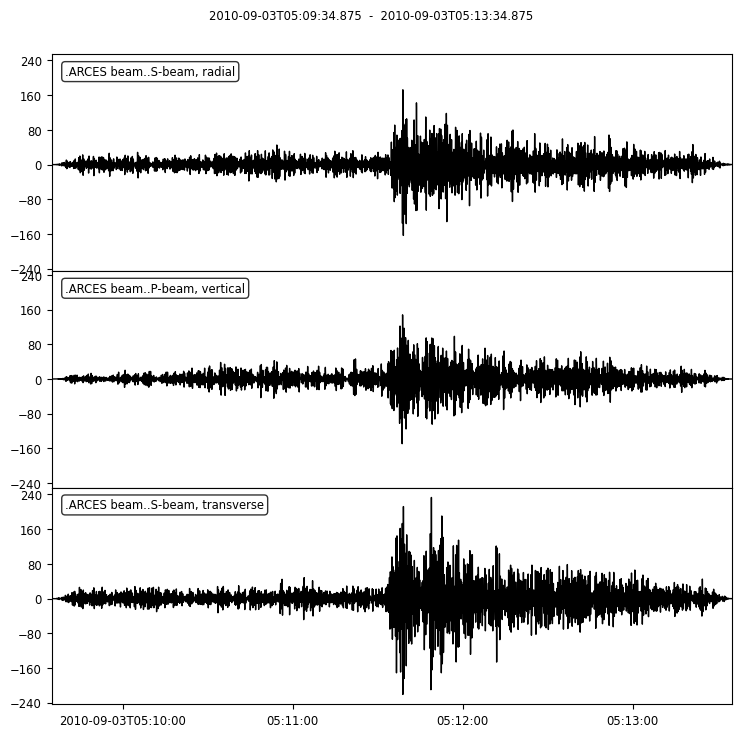

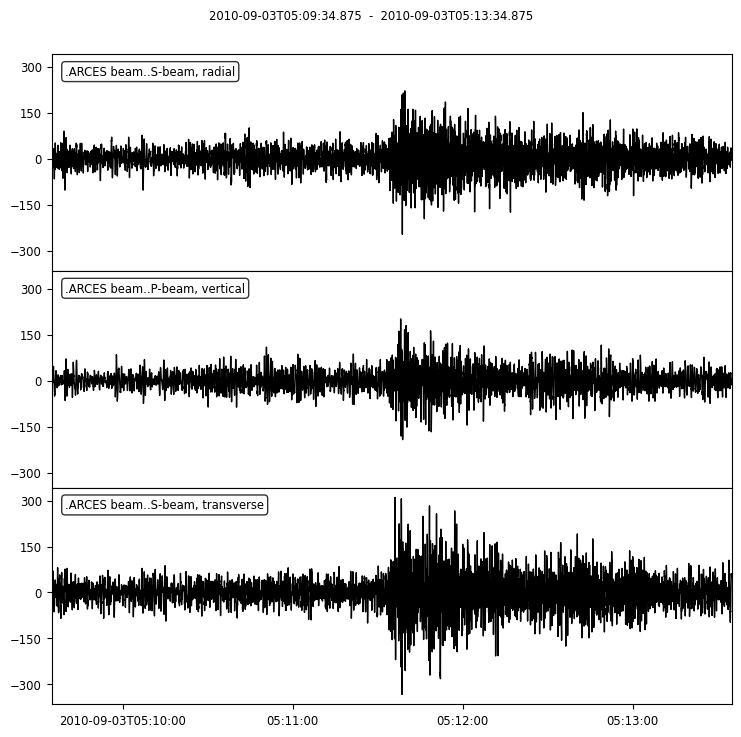

{   'analyst_pick_time': None,
    'az_to_arces': 160.3668495845376,
    'baz_to_arces': 347.40261094756227,
    'dist_to_arces': 852.3743910840693,
    'est_arrivaltime_arces': '2010-09-03 05:10:34.880000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.00289074850884038,
    'magnitude_sqrtdist_ratio': 0.08439670802692896,
    'magnitudes': [   {   'mag': 2.464,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/cdd34a43-0373-4a30-b59c-8b7ff5da4986',
                          'resource_id': 'smi:local/7dbb580d-0f7a-40ed-9d14-4ecda670dad7'},
                      {   'mag': 2.52,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/cdd34a43-0373-4a30-b59c-8b7ff5da4986',
                          'resource_id': 'smi:local/852b56a9-db97-4c09-8524-5b287fcff6c0'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 347.39951,
              

In [41]:
i = 6
print(labels[i])
helper.plot_event(traces[i], info[i])
helper.plot_event(handler.path_to_trace(train_ds[i][0])[0], handler.path_to_trace(train_ds[i][0])[1])
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info[i])

In [10]:
set([x['trace_stats']['sampling_rate'] for x in info])

{40.0}